In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [96]:
data = pd.read_csv("/kaggle/input/customer-lifetime-value-analytics-case-study/customer_acquisition_data.csv")
data.head()

,customer_id,channel,cost,conversion_rate,revenue
0,1,referral,8.320327,0.123145,4199
1,2,paid advertising,30.450327,0.016341,3410
2,3,email marketing,5.246263,0.043822,3164
3,4,social media,9.546326,0.167592,1520
4,5,referral,8.320327,0.123145,2419


## Data Cleaning

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      800 non-null    int64  
 1   channel          800 non-null    object 
 2   cost             800 non-null    float64
 3   conversion_rate  800 non-null    float64
 4   revenue          800 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 31.4+ KB


In [98]:
data.isnull().sum()

customer_id        0
channel            0
cost               0
conversion_rate    0
revenue            0
dtype: int64

In [99]:
data.duplicated().sum()

0

In [100]:
channelsC = data["channel"].value_counts()
channelsC

channel
email marketing     214
referral            207
paid advertising    194
social media        185
Name: count, dtype: int64

### Some visualizations 
since the data is clean, let's derive some insights from the data before processing

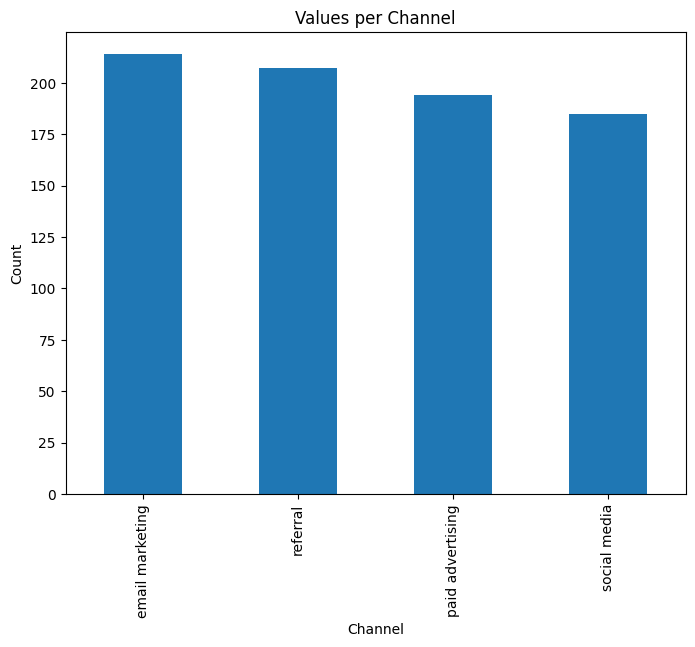

In [101]:
plt.figure(figsize = (8, 6))
channelsC.plot(kind = "bar")
plt.title("Values per Channel")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.show()

In [102]:
cost_per_channel = data.groupby("channel")["cost"].sum()
revenue_per_channel = data.groupby("channel")["revenue"].sum()

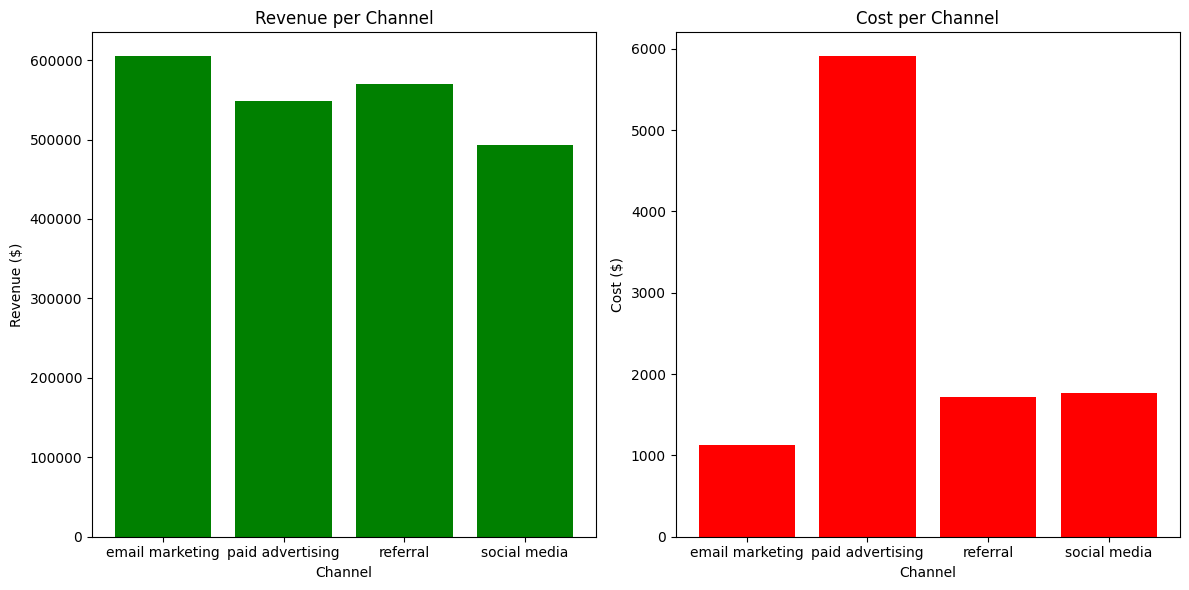

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(revenue_per_channel.index, revenue_per_channel, color='green')
axes[0].set_title('Revenue per Channel')
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Revenue ($)')

axes[1].bar(cost_per_channel.index, cost_per_channel, color='red')
axes[1].set_title('Cost per Channel')
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('Cost ($)')

# Adjust the layout to avoid overlap
plt.tight_layout()

plt.show()

### Some insights
Here we notice that paid advertising costs too much while it doesn't generate revenue the most like email marketing, so that gives us an idea, if we increased spending on email marketing then it will generate more revenue in general!
the same with social media and refferal, spending is even less than half of the revenue generated from them.

Now let's see what channel is more effective in making customers.

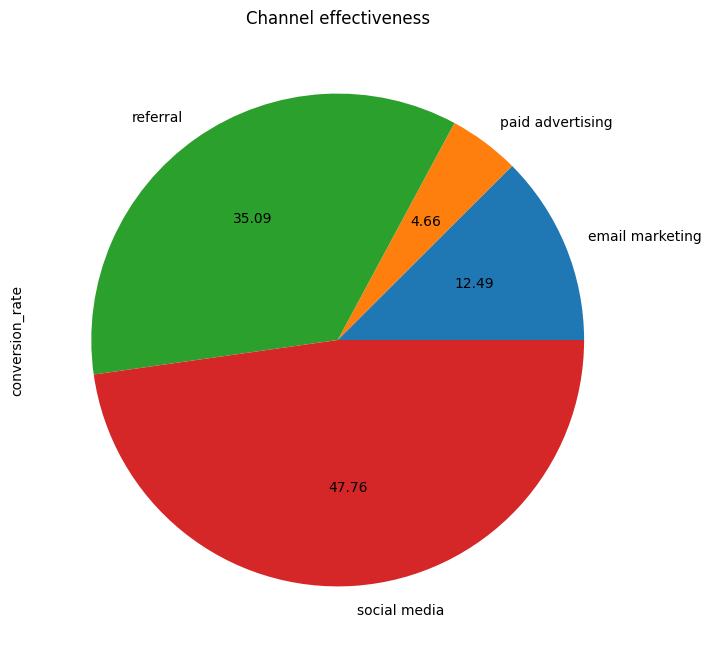

In [104]:
channel_conv = data.groupby("channel")["conversion_rate"].mean()
plt.figure(figsize = (10, 8))
channel_conv.plot.pie(subplots = True, fontsize = 10, autopct = "%.2f")
plt.title("Channel effectiveness")
plt.show()

..Social Media it is!

## Feature Engineering

In order to calculate the CLV to for later prediction, first we need to calculate some necessary metrics.



In [105]:
# we will assume that the customer lifespan is 3 years, since its not provided in the dataset
customer_lifespan = 3

# calculatng the CLV

data["CLV"] = (data['revenue'] * customer_lifespan) - data['cost']

In [106]:
data.head()

,customer_id,channel,cost,conversion_rate,revenue,CLV
0,1,referral,8.320327,0.123145,4199,12588.679673
1,2,paid advertising,30.450327,0.016341,3410,10199.549673
2,3,email marketing,5.246263,0.043822,3164,9486.753737
3,4,social media,9.546326,0.167592,1520,4550.453674
4,5,referral,8.320327,0.123145,2419,7248.679673


# Building the model and predicting

In [107]:
df = pd.get_dummies(data, columns=["channel"], drop_first=True)

X = df.drop(columns=["customer_id", "CLV"])
y = df["CLV"]

X_trai, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_trai)
X_test = scaler.transform(X_test)

In [109]:
model1 = RandomForestRegressor(n_estimators=100, random_state=0)
model2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
model3 = LinearRegression()
model4 = SVR(C=0.1, coef0=2.0, gamma=1, kernel='poly')
model5 = ElasticNet(random_state=10)

In [110]:
ensemble_model = VotingRegressor(estimators=[
    ('rf', model1), 
    ('gb', model2), 
    ('lr', model3), 
    ('sr', model4), 
    ('en', model5)])

ensemble_model.fit(X_train, y_train)

#predictions
y_preds = ensemble_model.predict(X_test)

In [111]:
mae_score = mean_absolute_error(y_test, y_preds)
print('MAE:', mae_score)

mse_score = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse_score}")

MAE: 475.75880340171227
Mean Squared Error: 425.9753664839092
